#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return "negative"
    return "positive"

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...



## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [9]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [10]:
print(final.shape)

(364171, 10)


In [11]:
final[30:50]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
final = final[final['ProductId'] != '2841233731']

In [13]:
final = final[final['ProductId'] != '0006641040']

In [14]:
final.shape

(364136, 10)

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364136, 10)


positive    307028
negative     57108
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

9
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


In [19]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'because', 'yours', "shan't", 'can', 'having', 'he', "haven't", "isn't", 'out', 'hers', 'wouldn', 'haven', 'when', 'how', "couldn't", "she's", 'this', 'both', 'd', 'than', 'doesn', 'i', 'after', 'should', "doesn't", "wasn't", 'under', 'is', "you'd", 'o', 'be', 'other', 'again', 'it', 'those', "aren't", 'for', 'once', 'further', 'himself', 'then', 've', 'up', "you've", 'more', 'between', 'why', 'as', 'my', 'her', 'theirs', 'very', 'with', 'do', 'from', "hasn't", "you'll", 'who', 'couldn', 'few', 'same', 'yourself', 'so', 'by', 'below', "it's", 'don', 'she', 'isn', 'against', 'just', 'to', 'didn', 'which', 'him', 'did', "wouldn't", 'some', 'over', 'our', 'themselves', 'its', 'each', 't', "don't", 'these', 'were', 'or', 'an', 'me', 'there', "weren't", 'during', 'above', 'them', 'where', 'needn', 'that', 'too', 'shouldn', 'you', 'won', "that'll", 'had', 'before', 'only', 'y', 'whom', 'mightn', 'm', 'your', 'not', "should've", "didn't", 'are', 'was', 'being', 'has', 'now', 'no', 'nor', 'ha

In [20]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [21]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


In [64]:
# Using only 5k rows for further analysis as my RAM is only 8 GB
my_final = final[0:5000]

In [23]:
my_final.shape

(5000, 11)

In [24]:
my_final['Score'].value_counts()

positive    4105
negative     895
Name: Score, dtype: int64

In [25]:
my_final['CleanedText'].values.shape

(5000,)

In [63]:
# the below code was fully motivated by the source given below
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews
#/blob/master/t-SNE%20visualization%20of%20Amazon%20reviews%20with%20polarity%20based%20color-
#coding.ipynb

# Bag of Words (BoW)

In [26]:
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn
final_counts = count_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 2233)
the number of unique words  2233


In [27]:
# Change sparse matrix to dense matrix
final_counts  = final_counts.toarray()

In [28]:
final_counts.shape

(5000, 2233)

In [29]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts)
print(standardized_data.shape)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(5000, 2233)


In [30]:
my_final['Score'].shape

(5000,)

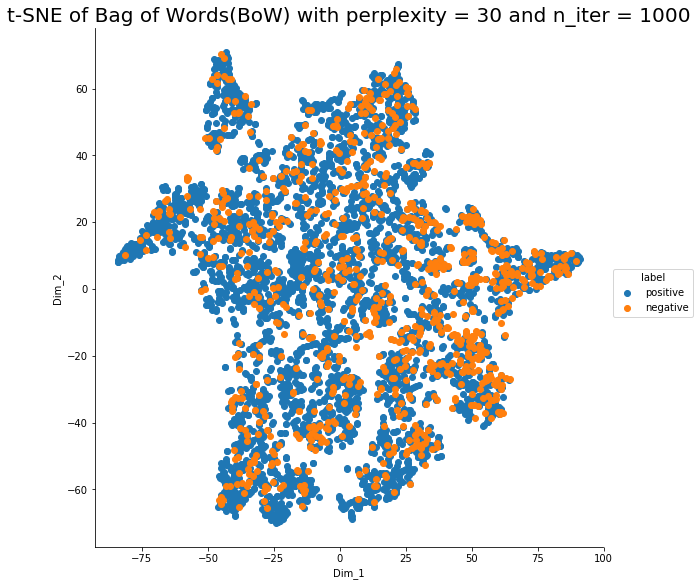

In [60]:
# TSNE

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)

# number of components = 2
# perplexity = 30
# learning rate = 200
#  Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 30 and n_iter = 1000',size=20)
plt.show()

# Bi-Grams and n-Grams.



In [32]:
#Bi-Gram
count_vect = CountVectorizer(ngram_range=(1,2),min_df=5 ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 7651)
the number of unique words including both unigrams and bigrams  7651


In [33]:
# sparse matrix to dense matrix
final_bigram_counts  = final_bigram_counts.toarray()

In [34]:
final_bigram_counts.shape

(5000, 7651)

In [35]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_bigram_counts)
print(standardized_data.shape)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(5000, 7651)


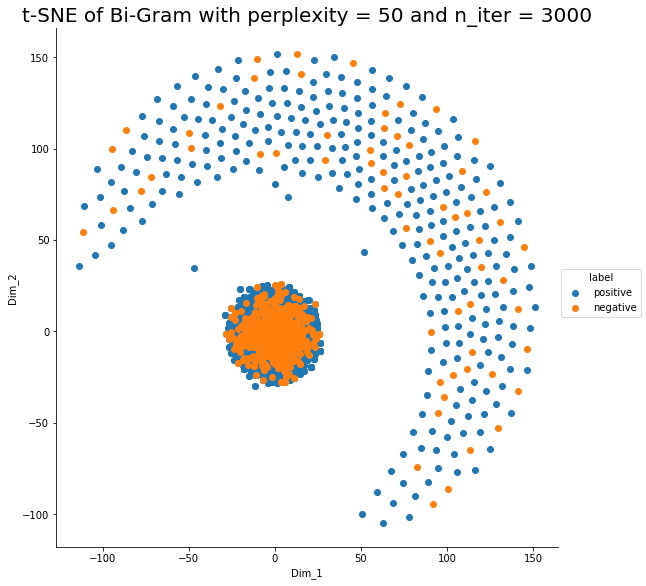

In [36]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bi-Gram with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

#  TF-IDF

In [37]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
final_tf_idf = tf_idf_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 7651)
the number of unique words including both unigrams and bigrams  7651


In [38]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1000:1020])

some sample features(unique words in the corpus) ['caught', 'caught first', 'caught mole', 'caught one', 'caus', 'caus dog', 'caus pet', 'caution', 'cautious', 'cavali', 'caveat', 'cayenn', 'cayenn pepper', 'celesti', 'celesti good', 'cent', 'center', 'central', 'centuri', 'ceram']


In [39]:
# sparse matrix to dense matrix
final_tf_idf  = final_tf_idf.toarray()

In [40]:
final_tf_idf.shape

(5000, 7651)

In [41]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_tf_idf)
print(standardized_data.shape)

(5000, 7651)


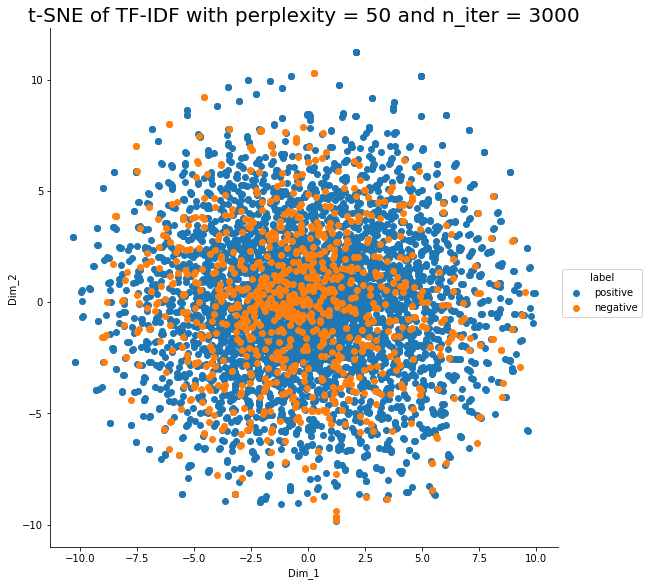

In [42]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


#a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TF-IDF with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

# Word2Vec

In [43]:
# Train your own Word2Vec model using your own text corpus
list_of_sent=[]
for sent in my_final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [44]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

product archer farm best drink mix ever mix flavor packet water bottl contain natur sweetner stevia real fruit flavor food color color fruit veget color pure natur tast great eight packet box contain calori per packet thank archer farm
*****************************************************************
['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'mix', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'flavor', 'food', 'color', 'color', 'fruit', 'veget', 'color', 'pure', 'natur', 'tast', 'great', 'eight', 'packet', 'box', 'contain', 'calori', 'per', 'packet', 'thank', 'archer', 'farm']


# 

In [45]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [46]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  3627


#  Avg W2V, TFIDF-W2V

In [59]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
50


In [48]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(5000, 50)


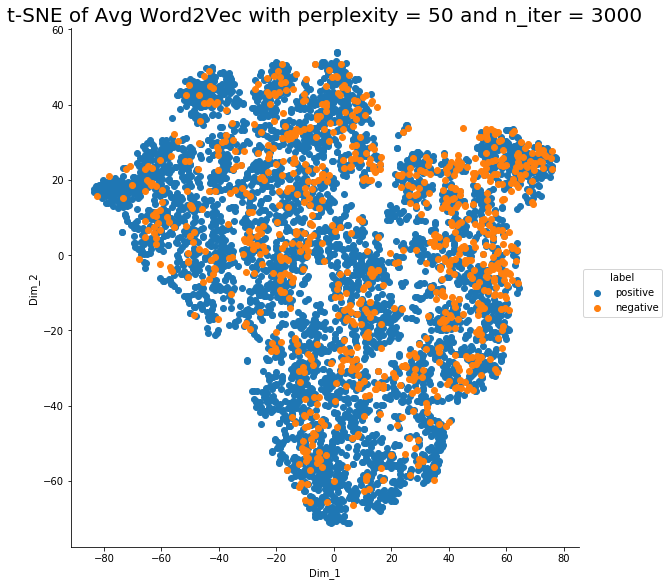

In [49]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Avg Word2Vec with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

In [50]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(my_final['CleanedText'].values)

In [51]:
final_tf_idf.shape

(5000, 10410)

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [57]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review
    sent_vec = np.zeros(50) # word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the review
    for word in sent: # for each word in a review
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [55]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(5000, 50)


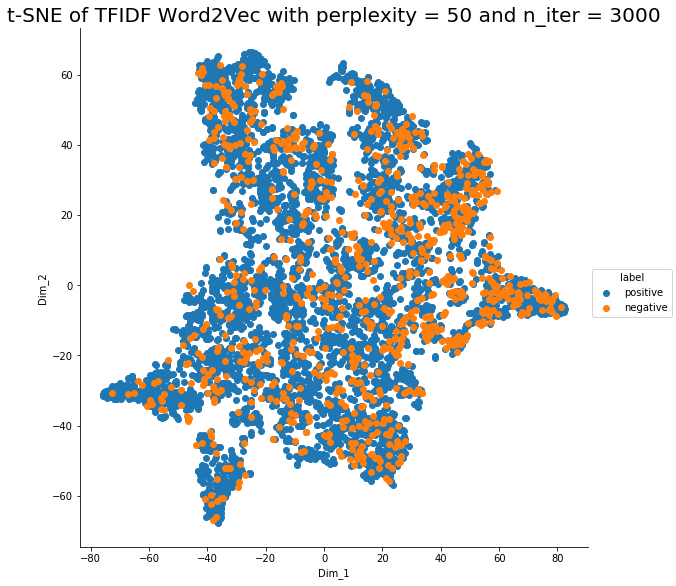

In [56]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TFIDF Word2Vec with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

# Conclusion

note:for various size of data give various shape in all cases with different perplexitity and iterations 



from above we can see clearly that most of positive and neagtive overlap , only in case of bag of words and bi-gram its little
different but it cannot also conclude that it will not as for higher perplexity it could be the same or vice-versa to other resulting models